In [9]:
import sqlite3
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.checkpoint.sqlite import SqliteSaver

llm = init_chat_model("openai:gpt-5-nano")

conn = sqlite3.connect(
    "memory.db",
    check_same_thread=False,
)

In [10]:
class State(MessagesState):
    custom_stuff: str

graph_builder = StateGraph(State)

In [11]:
@tool
def get_weather(city: str):
    """Gets weather in city"""
    return f"The weather in {city} is sunny."


llm_with_tools = llm.bind_tools(tools=[get_weather])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [12]:
tool_node = ToolNode(
    tools=[get_weather],
)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

# graph = graph_builder.compile(
#     checkpointer=SqliteSaver(conn),
# )

graph = graph_builder.compile(
    checkpointer=SqliteSaver(conn),
)

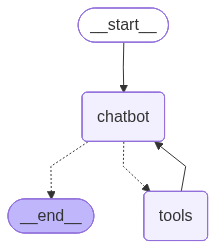

In [13]:
graph

In [14]:
for event in graph.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is the weather in berlin, budapest and bratislava.",
            },
        ]
    },
    stream_mode="updates",
    config={
        "configurable": {
            "thread_id": "5",
        },
    },
):
    print(event)

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LsvC98KL3p7KYn4vpCDaH3cl', 'function': {'arguments': '{"city": "Berlin"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_7cN33nzbfzFmcmcghCu3NgS8', 'function': {'arguments': '{"city": "Budapest"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_uOxgCNVmO19OQFoyQXevz9wW', 'function': {'arguments': '{"city": "Bratislava"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 518, 'prompt_tokens': 137, 'total_tokens': 655, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CXieT29ude79UnR3b4RtqFMgC9e9X', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs

In [6]:
async for event in graph.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is the weather in berlin, budapest and bratislava.",
            },
        ]
    },
    stream_mode="updates",
    # config={
    #     "configurable": {
    #         "thread_id": "1",
    #     },
    # },
):
    print(event)

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dJLEfidtHOg5naQaidf5LUgb', 'function': {'arguments': '{"city": "Berlin"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_U0Q4unH1hiA6dWwHGua79M8p', 'function': {'arguments': '{"city": "Budapest"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_P6vpgmTtiinFEt5F1RlbCF84', 'function': {'arguments': '{"city": "Bratislava"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 326, 'prompt_tokens': 137, 'total_tokens': 463, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CXibUKDjAuRdIfyLnxcFt2IRZqbxm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs

In [8]:
for state in graph.get_state_history(
    {
        "configurable": {
            "thread_id": "1",
        },
    }
):
    print(state.next)

ValueError: No checkpointer set